## Setup

In [1]:
! mamba install polars -y


Looking for: ['polars']

[+] 0.0s
[+] 0.1s
rapidsai/linux-64 (check zst) ━━━━━━━━━━━━━╸━   0.0 B @  ??.?MB/s Checking  0.1s[+] 0.2s
rapidsai/linux-64 (check zst) ━━━━━━━━━━━━━━━   0.0 B @  ??.?MB/s Checking  0.2s[+] 0.3s
rapidsai/linux-64 (check zst) ━━━━━━━━━━━━━━━   0.0 B @  ??.?MB/s Checking  0.3srapidsai/linux-64 (check zst)                       Checked  0.4s
[+] 0.0s
[+] 0.1s
rapidsai/noarch (check zst) ━━━━━━━╸━━━━━━━━━   0.0 B @  ??.?MB/s Checking  0.1srapidsai/noarch (check zst)                         Checked  0.1s
[+] 0.0s
pytorch/linux-64 (check zst)                       Checked  0.1s
[+] 0.0s
[+] 0.1s
pytorch/noarch (check zst) ━━━━━━━━╸━━━━━━━━━   0.0 B @  ??.?MB/s Checking  0.1spytorch/noarch (check zst)                          Checked  0.1s
[+] 0.0s
nvidia/linux-64 (check zst) ━━━━━━━━━━╸━━━━━━   0.0 B @  ??.?MB/s Checking  0.0s[+] 0.1s
nvidia/linux-64 (check zst) ━━━━━━━━━━╸━━━━━━   0.0 B @  ??.?MB/s Checking  0.1s[+] 0.2s
nvidia/linux-64 (check zst) ━━━━━━━━━━╸━━━━

## Config

In [5]:
data = "data_10b.txt"
!ls -lh {data}

-rw-r--r-- 1 rapids conda 129G Jan 18 14:55 data_10b.txt


### Pandas

In [3]:
%%time
import pandas as pd

df = pd.read_csv(
    data, sep=";", header=None, names=["station", "measure"], engine="pyarrow"
)
df = df.groupby("station").agg(["min", "max", "mean"])
df.columns = df.columns.droplevel()
df = df.sort_values("station")
df.head()

KeyboardInterrupt: 

### Polars

In [2]:
%%time
import polars as pl

df = pl.scan_csv(
    data,
    separator=";",
    has_header=False,
    with_column_names=lambda cols: ["city", "value"],
)

grouped = (
    df.group_by("city")
    .agg(
        pl.min("value").alias("min"),
        pl.mean("value").alias("mean"),
        pl.max("value").alias("max"),
    )
    .sort("city")
    .collect(streaming=True)
)

CPU times: user 34min 4s, sys: 2min 13s, total: 36min 17s
Wall time: 6min 25s


### dask

In [3]:
%%time
import dask
import dask.dataframe as dd
from dask.distributed import Client

client = Client()
df = dd.read_csv(
    data,
    sep=";",
    header=None,
    names=["station", "measure"],
    engine="pyarrow",
)
df = df.groupby("station").agg(["min", "max", "mean"])
df.columns = df.columns.droplevel()
df = df.sort_values("station").compute()
df.head()

/opt/conda/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39315 instead
  warnings.warn(


CPU times: user 52.3 s, sys: 11.2 s, total: 1min 3s
Wall time: 11min 12s


,min,max,mean
station,,,
Abha,-35.1,74.1,18.001378
Abidjan,-29.3,76.2,26.001499
Abéché,-26.7,83.2,29.399110
Accra,-27.6,84.6,26.398555
Addis Ababa,-39.8,69.9,16.002558


### dask-cudf

In [4]:
%%time
import dask
import dask.dataframe as dd
from dask.distributed import Client
from dask_cuda import LocalCUDACluster

client = Client(LocalCUDACluster())

with dask.config.set({"dataframe.backend": "cudf"}):
    df = dd.read_csv(
        data,
        sep=";",
        header=None,
        names=["station", "measure"],
    )
    df = df.groupby("station").agg(["min", "max", "mean"])
    df.columns = df.columns.droplevel()
    df = df.compute().to_pandas().sort_values("station")
    df.head()

/opt/conda/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44151 instead
  warnings.warn(


CPU times: user 13.4 s, sys: 3.4 s, total: 16.8 s
Wall time: 1min 27s


### cudf

In [3]:
%%time
import cudf

df = cudf.read_csv(
    "1brc/measurements.txt", sep=";", header=None, names=["station", "measure"]
)
df = df.groupby("station").agg(["min", "max", "mean"])
df.columns = df.columns.droplevel()
df = df.sort_values("station")

MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /opt/conda/include/rmm/mr/device/cuda_memory_resource.hpp

### cudf.pandas

In [1]:
%load_ext cudf.pandas

In [2]:
%%time
%%cudf.pandas.profile
import pandas as pd

df = pd.read_csv(
    "1brc/measurements.txt",
    sep=";",
    header=None,
    names=["station", "measure"],
    engine="pyarrow",
)
df = df.groupby("station").agg(["min", "max", "mean"])
df.columns = df.columns.droplevel()
df = df.sort_values("station")
df.head()

,measure,measure,measure
station,,,
Abha,-31.2,65.2,18.004827
Abidjan,-23.1,73.1,26.010195
Abéché,-20.7,77.3,29.405662
Accra,-21.8,77.3,26.399376
Addis Ababa,-37.6,64.7,15.991643


                                                                                                                
                                          Total time elapsed: 561.227 seconds                                   
                                         2 GPU function calls in 0.175 seconds                                  
                                        7 CPU function calls in 398.586 seconds                                 
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ read_csv                   │ 0          │ 0.000       │ 0.000       │ 1          │ 50.251      │ 50.251      │
│ DataFrame.groupby          │ 0          │ 0.000       │ 0.000       │ 1          │ 77.734      │ 77.734      │
│ DataFrameGroupBy.aggregate │ 0          │ 0.000       │ 0.000       │ 1          │ 270.515     │ 270.515     │
│ MultiIndex.droplevel       │ 1          │ 0.175       │ 0.175       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.__setattr__      │ 0          │ 0.000       │ 0.000       │ 1          │ 0.055       │ 0.055       │
│ DataFrame.sort_values      │ 0          │ 0.000       │ 0.000       │ 1          │ 0.003       │ 0.003       │
│ DataFrame.head             │ 0          │ 0.000       │ 0.000       │ 1          │ 0.001       │ 0.001       │
│ DataFrame                  │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.__repr__         │ 0          │ 0.000       │ 0.000       │ 1          │ 0.026       │ 0.026       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- read_csv
- DataFrame.groupby
- DataFrameGroupBy.aggregate
- DataFrame.__setattr__
- DataFrame.sort_values
- DataFrame.head
- DataFrame.__repr__

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=390246;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

CPU times: user 10min 46s, sys: 1min 11s, total: 11min 57s
Wall time: 9min 21s


## Timings

<Axes: title={'center': 'Ten Billion Row Challenge'}, ylabel='Time (seconds)'>

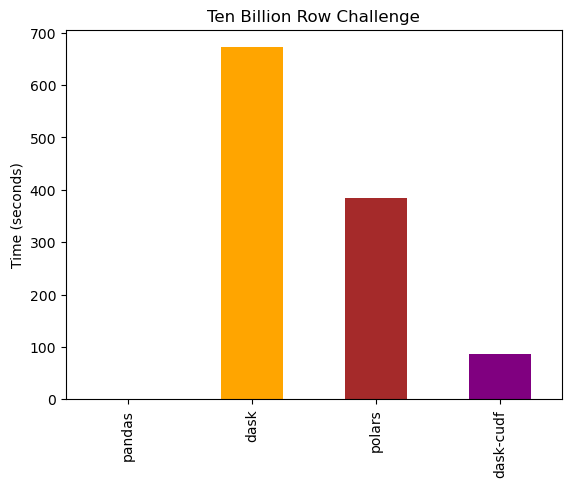

In [1]:
import pandas as pd

s = pd.Series({"pandas": 0, "dask": 672, "polars": 385, "dask-cudf": 87})
s.plot.bar(
    title="Ten Billion Row Challenge",
    stacked=True,
    color=["blue", "orange", "brown", "purple"],
    ylabel="Time (seconds)",
)